# Customer Booking Classification: Leveraging Machine Learning for Predictive Insights
In the competitive airline industry, understanding and predicting customer behavior is paramount for enhancing service quality and operational efficiency. This project focuses on developing a machine learning model to predict whether a customer booking will be completed based on various features extracted from booking data. By accurately predicting booking completion, airlines can implement proactive strategies to improve customer experience and optimize resource allocation.
## Objective
To build a robust machine learning model that accurately predicts customer booking completion, and to determine what key factors influences the completion of a booking
## Steps
Data Cleaning and Preprocessing: Handle duplicates, outliers, and convert categorical variables to numerical representations to ensure data quality.
Feature Engineering: Extract and transform features such as flight_day to integers representing days of the week and extract continent names from country names.
Model Training and Evaluation: Train multiple machine learning models (Logistic Regression, Decision Tree, Voting Classifier, Random Forest and XGBoost) and select the best-performing model based on cross-validation scores.
Performance Metrics: Evaluate models using accuracy, F1 score, confusion matrix, precision recall and ROC curve to ensure robust performance, particularly for imbalanced datasets.

In [14]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from ydata_profiling import ProfileReport
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, QuantileTransformer, OneHotEncoder
from scipy.stats import boxcox, yeojohnson
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [15]:
# Importing Dataset
data = pd.read_csv('customer_booking.csv', encoding= 'latin')
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [16]:
# Checking data types
data.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [17]:
# Checking data summary
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


## Make a new feature

Encoding the flight day column manually by mapping

In [18]:
# Converting data types
data.dtypes
converts = ['sales_channel','trip_type','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals','flight_day','booking_complete']

# Create a mapping dictionary
day_to_int = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}

# Apply the mapping
data['flight_day'] = data['flight_day'].map(day_to_int)

# Verify the conversion
# Further data type conversions
data[converts] = data[converts].astype('category')


# EDA

## Outliers

<Axes: >

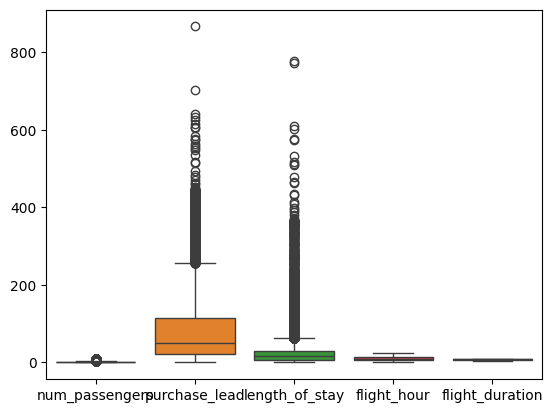

In [19]:
# Detecting outliers
sns.boxplot(data)

In [20]:
# Checking for non positive values
print(data['length_of_stay'].min(),data['purchase_lead'].min())

0 0


### Distribution

(0.0, 867.0)

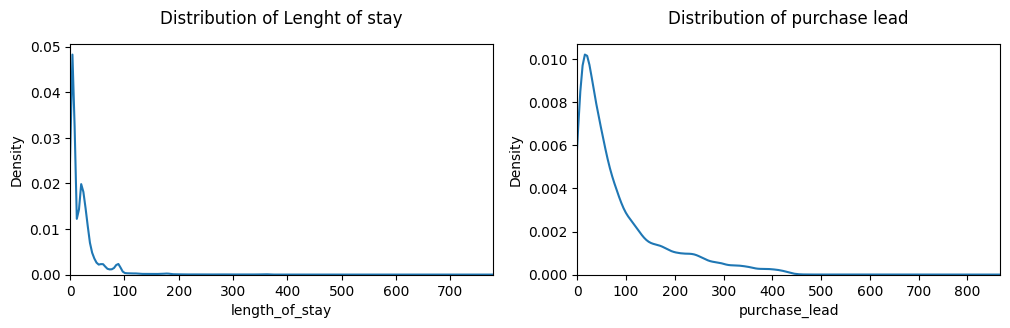

In [21]:
# Plotting lenght of stay and purchase lead distribution
fig, ax = plt.subplots(nrows=1,ncols=2,figsize= (12,3))
sns.kdeplot(data= data, x= 'length_of_stay',ax= ax[0]).set_title('Distribution of Lenght of stay', y= 1.05)
ax[0].set_xlim(data['length_of_stay'].min(), data['length_of_stay'].max())

sns.kdeplot(data= data, x= 'purchase_lead', ax= ax[1]).set_title('Distribution of purchase lead', y= 1.05,)
ax[1].set_xlim(data['purchase_lead'].min(), data['purchase_lead'].max())

In [22]:
# Dropping outliers
data.drop(index= data[data['length_of_stay']>100].index,inplace= True)
data.drop(index= data[data['purchase_lead']>450].index,inplace= True)

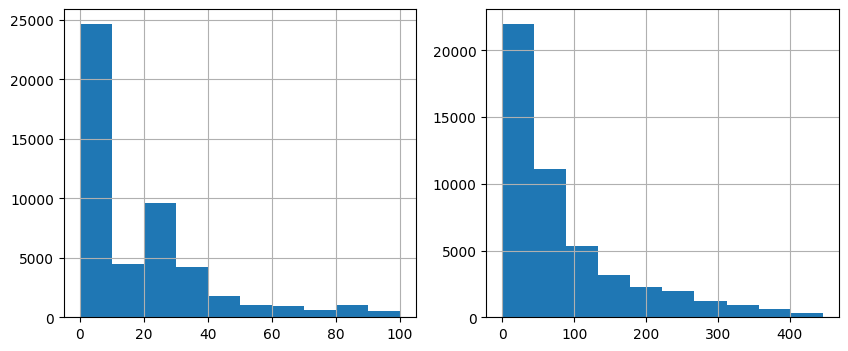

In [23]:
# Re visualizing distribution
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (10,4))
data['length_of_stay'].hist(ax=ax[0])
data['purchase_lead'].hist(ax=ax[1])
plt.show()

Distribution to lenght of stay and purchase lead is rightly skewed but to be transformed into normal distribution later

# Make a machine learning Model

## Data Preparation

### Feature Engineering

In [24]:
# Importing pycountry library for mapping country to continent
import pycountry
import pycountry_convert as pc 
mode = data['booking_origin'].mode()[0]
# replacing irregular country names 
data['booking_origin'] =  data['booking_origin'].replace({'Myanmar (Burma)':'Myanmar','(not set)': mode})
# Splitting values with multiple country names into new row
data['booking_origin'] = data['booking_origin'].str.split('&')
data = data.explode('booking_origin')
# removing whitespaces
data['booking_origin'] = data['booking_origin'].str.strip()
data = data.loc[data['booking_origin']!='Jan Mayen']

# Defining country to continent function
def get_continent_name(country_name):
    try:
        country_code = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (LookupError, KeyError):
        return 'Others'

# transforming country names to continent names using function
continent_names = data['booking_origin'].apply(get_continent_name)
data['booking_continent'] = continent_names
others = data[data['booking_continent']=='Others']
data['booking_continent'].unique()

array(['Oceania', 'Asia', 'Europe', 'Africa', 'North America',
       'South America', 'Others'], dtype=object)

the booking origin column also has many unique values, but because I don't want to delete the information on the origin of the booking, I will extract what continent the value of the booking origin belongs, and irrespective of the lenght of countries available ill be keeping them to be transform later as additional information to the model

In [25]:
# Identify countries under other continents
others = data[data.booking_continent=='Others']
others['booking_origin'].unique()

array(['Turkey', 'Brunei', 'Russia', 'Timor-Leste', 'Macau', 'Svalbard'],
      dtype=object)

In [26]:
# Define the dictionary for continent mapping
dict = {'Turkey': 'Asia', 'Brunei': 'Asia', 'Russia': 'Asia', 'Timor-Leste': 'Asia', 'Macau': 'Asia', 'Svalbard': 'Europe'}

# Use .loc to update 'booking_continent' in 'data' DataFrame where 'booking_origin' matches
data.loc[data['booking_origin'].isin(dict.keys()), 'booking_continent'] = data['booking_origin'].map(dict)

# Verify the unique values in the 'booking_continent' column
data['booking_continent'].unique()


array(['Oceania', 'Asia', 'Europe', 'Africa', 'North America',
       'South America'], dtype=object)

In [28]:
# Determining weekend days 
data['flight_day'] = data['flight_day'].astype('int64')
data['is_weekend'] = np.where(data.flight_day<5,0,1)
# Converting data types
data['flight_day'] = data['flight_day'].astype('category')
data['is_weekend'] = data['is_weekend'].astype('category')
data['booking_continent'] = data['booking_continent'].astype('category')

# Displaying data after change
display(data.sample())
data.dtypes

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,booking_continent,is_weekend
15503,1,Internet,RoundTrip,7,62,4,3,JHBKTM,Malaysia,1,0,0,4.75,0,Asia,0


num_passengers              int64
sales_channel            category
trip_type                category
purchase_lead               int64
length_of_stay              int64
flight_hour                 int64
flight_day               category
route                      object
booking_origin             object
wants_extra_baggage      category
wants_preferred_seat     category
wants_in_flight_meals    category
flight_duration           float64
booking_complete         category
booking_continent        category
is_weekend               category
dtype: object

Both new features `booking_continent` and `is_weekend` has been successfully created

### Creating transformers

In [32]:
# Import Binary Encoder
from category_encoders import BinaryEncoder

In [47]:
# Defininig features columns
nums = data.select_dtypes('number').columns
ordinal = ['sales_channel','trip_type']
skew = ['length_of_stay','purchase_lead']
onehot = ['booking_continent']
binary = ['booking_origin','route']
skip_features = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals','is_weekend','flight_day']

# Creation transformer objects 
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
binary_encoder = BinaryEncoder()
normal_dist = QuantileTransformer(output_distribution='normal', random_state=42)

# Defining column tranformer
transformer = ColumnTransformer([('skew',normal_dist,skew),
                                 ('nums',scaler,nums),
                                 ('skip', 'passthrough', skip_features),
                                 ('onehot',encoder,onehot),
                                 ('ordinal',ordinal_encoder,ordinal),
                                 ('binary',binary_encoder,binary)
                                 ],remainder='passthrough')



### Itemizing models for comparison

In [56]:
# defining models for comparison
models = {'LogReg': LogisticRegression(max_iter=200,class_weight='balanced'),
          'DecisionTree': DecisionTreeClassifier(), 
          'VotingClass':VotingClassifier(estimators=[('LogReg', LogisticRegression(max_iter=200,class_weight='balanced')),
                                                     ('DecisionTree', DecisionTreeClassifier())]), 
            'Random_forest': RandomForestClassifier(),
            'xgb':XGBClassifier()}

### Selecting features and target

In [57]:
# Defining features and target variables
features = data.drop(columns=['booking_complete']).columns
target = 'booking_complete'

### Comparing models

In [58]:
# Splitting dataset 
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3,stratify=y,shuffle= True, random_state= 42)
# Comparing models
result = {}
for key, val in models.items():
    pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('model', val)])
    cross_val = cross_val_score(pipeline, X_train, y_train, cv= 5,scoring='precision')
    result[key] = np.mean(cross_val)

print(result)

{'LogReg': 0.26360801939888184, 'DecisionTree': 0.2714802089032432, 'VotingClass': 0.3446307718663161, 'Random_forest': 0.455237963161718, 'xgb': 0.431594966701109}


### Best Model (RandomForestClassifier)

In [65]:
# Creating pipeline for best model (RandomForestClassifier)
pipeline = Pipeline(steps=[
    ('preprocessor', transformer),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier())
])


# Fit and evaluate model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = pipeline.score(X_test, y_test)
y_prob = pipeline.predict_proba(X_test)[:1]
# Evaluating model
print(f"Test Score: {score}")
print('precision:', precision_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

Test Score: 0.8472563472563472
precision: 0.48311156601842375
0.29666876178504087


### Evaluating model

In [60]:
from sklearn.metrics import roc_auc_score
print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, pipeline.predict(X_train)),
      "roc_auc (test-proba): %.2f",roc_auc_score(y_test, y_pred))

roc_auc (train-proba): 1.00 roc_auc (test-proba): %.2f 0.5890226806557763


Text(0.5, 1.0, 'RandomForest Confusion_Matrix')

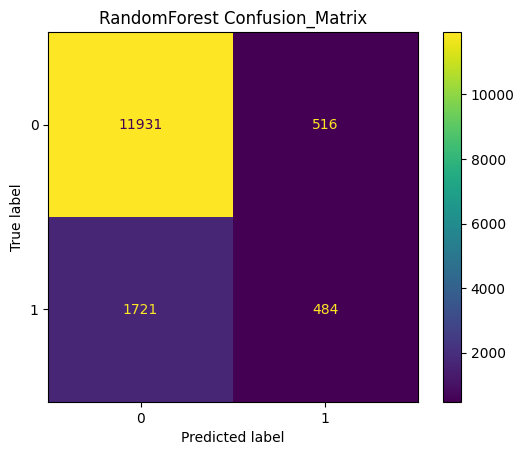

In [61]:
# Importing Confusion Matrix Library
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmd.plot()
plt.title('RandomForest Confusion_Matrix')

### Getting Insight on most influencial features

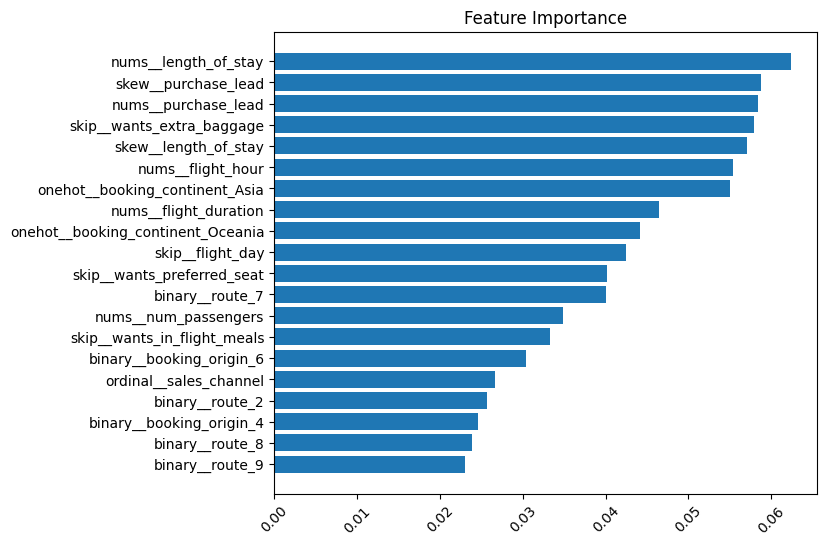

In [74]:

importance = pipeline.named_steps['model'].feature_importances_
coeff = pd.DataFrame({'importance': importance}, index=pipeline.named_steps['preprocessor'].get_feature_names_out()).sort_values(by='importance').tail(20)
plt.figure(figsize=(7, 6))
plt.barh(y=coeff.index, width=coeff['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.show()


### ROC

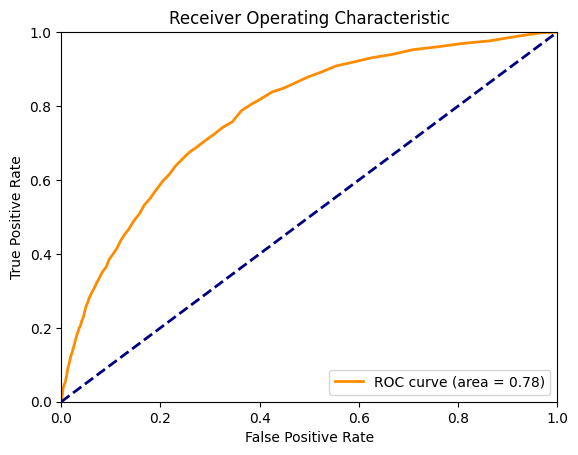

In [63]:
from sklearn.metrics import roc_curve, auc,roc_auc_score    

y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# From features Importance :
- The most important variable in the model was lenght_of_stay followed by purchase_lead, wants_extra_baggage and flight_duration.
- booking origin and route were least important


# Results
Best Model: The Random Forest classifier showed the highest performance in cross-validation and was selected as the final model.
Performance Metrics: The model achieved an accuracy of 84.7% and a precisiom score of 0.48 and f1_score 0.28. Despite high accuracy, the low F1 score indicates challenges in predicting the minority class, highlighting the need for further improvement.
Confusion Matrix and ROC Curve: Detailed analysis of the confusion matrix and ROC curve provided insights into model performance, particularly in identifying false positives and negatives.